# Example of Range-AUC

In [1]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
import math
import matplotlib.pyplot as plt
import pandas as pd
from RangeAUC.feature import Window
from sklearn.preprocessing import MinMaxScaler
from RangeAUC.metrics import metricor
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Prepare data

In [2]:
filepath = './data/MBA_ECG805_data.out'
df = pd.read_csv(filepath, header=None).to_numpy()

name = filepath.split('/')[-1]
max_length = 10000

data = df[:max_length,0].astype(float)
label = df[:max_length,1]
    
slidingWindow = 100
X_data = Window(window = slidingWindow).convert(data).to_numpy()

## Apply anomaly detector to obtain the anomaly score
In this example, we apply LOF in sklearn

In [3]:
modelName='LOF'

clf = LocalOutlierFactor(n_neighbors=20)
clf.fit(X_data)

# Invert decision_scores_. Outliers comes with higher outlier scores
score = -clf.negative_outlier_factor_
        
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))


Text(0, 0.5, 'Anomaly Score')

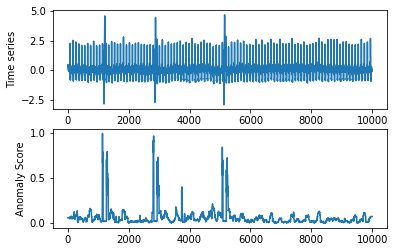

In [4]:
plt.subplot(2,1,1)
plt.plot(data)
plt.ylabel('Time series')
plt.subplot(2,1,2)
plt.plot(score)
plt.ylabel('Anomaly Score')

## Comparison among 3 versions of AUC with different buffer region

Text(0.5, 0, 'FPR')

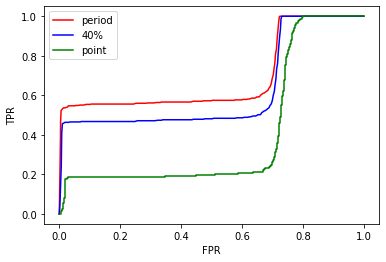

In [5]:
AUC_range, AP_range, fpr, tpr, prec\
=metricor().RangeAUC(labels=label, score=score, 
                     window=slidingWindow, percentage=0, plot_ROC=True, AUC_type='window')

plt.plot(fpr,tpr,'r')

AUC_range, AP_range, fpr, tpr, prec\
=metricor().RangeAUC(labels=label, score=score, 
                     window=0, percentage=.4, plot_ROC=True, AUC_type='percentage')

plt.plot(fpr,tpr,'b')

L, fpr, tpr = metricor().metric_new(label, score, plot_ROC=True, alpha=0.2)
plt.plot(fpr,tpr,'g')
plt.legend(['period','40%','point'])
plt.ylabel('TPR')
plt.xlabel('FPR')

## Varying the size of buffer region and obtain the AUC_volume

In [6]:
tpr_3d, fpr_3d, prec_3d, window_3d, avg_auc_3d, avg_ap_3d = metricor().RangeAUC_volume(labels_original=label, score=score, windowSize=slidingWindow)

X = np.array(tpr_3d).reshape(1,-1).ravel()
X_ap = np.array(tpr_3d)[:,:-1].reshape(1,-1).ravel()
Y = np.array(fpr_3d).reshape(1,-1).ravel()
W = np.array(prec_3d).reshape(1,-1).ravel()
Z = np.repeat(window_3d, len(tpr_3d[0]))
Z_ap = np.repeat(window_3d, len(tpr_3d[0])-1)

<ipython-input-7-84618a973237>:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Text(0.5, 0, 'window')

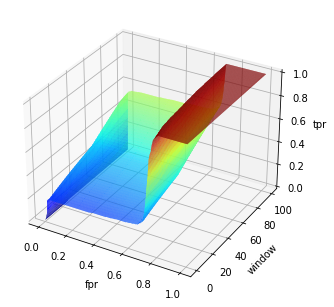

In [7]:
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(Y, Z, X, cmap=cm.jet, linewidth=0.1)
# fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('fpr')
ax.set_zlabel('tpr')
ax.set_ylabel('window')  